Перед запуском убедитесь, что в корне проекта есть файл .env и в нем заполнены выданные вам креды подключения к базам данных и хранилищу

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine

In [4]:
# подгружаем .env
load_dotenv()

True

In [5]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [6]:
# Создадим соединения
src_conn = create_engine(f'postgresql://{src_username}:{src_password}@{src_host}:{src_port}/{src_db}')
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

In [7]:
# Пример выгрузки данных из БД
TABLE = 'flats_character'
SQL = f'select * from {TABLE}'
data = pd.read_sql(SQL, dst_conn)

А дальше, творите!

<Axes: xlabel='studio', ylabel='Count'>

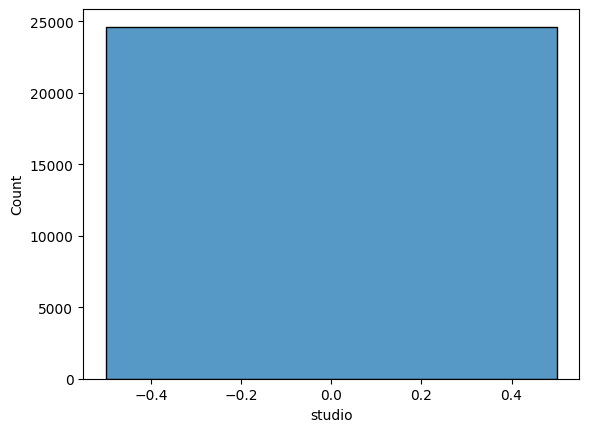

In [9]:
import seaborn as sns
sns.histplot(data['studio']) 

<Axes: xlabel='is_apartment', ylabel='Count'>

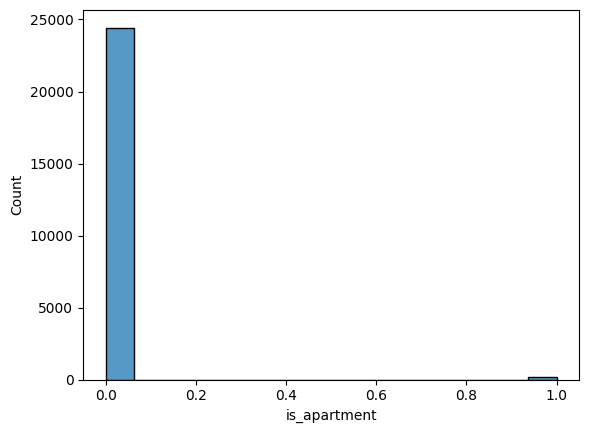

In [12]:
sns.histplot(data['is_apartment']) 

In [13]:
print(data)

           id  building_id  build_year  building_type_int   latitude  \
0       74094         1094        1950                  1  55.760925   
1       99548        13126        1980                  4  55.874805   
2       74098           88        1908                  1  55.753746   
3          32        12523        1978                  6  55.747570   
4       99553        20985        2008                  4  55.503925   
...       ...          ...         ...                ...        ...   
24615  141289        13923        1983                  4  55.798008   
24616  141307        18289        2001                  4  55.884998   
24617   11320        21544        2010                  2  55.715485   
24618    7793        12708        1979                  4  55.809925   
24619  141359         3162        1960                  1  55.727470   

       longitude  ceiling_height  flats_count  floors_total  has_elevator  \
0      37.541233            3.00           45             

In [13]:
features = data.drop(['building_id', 'target'], axis = 1)
print(features.dtypes.value_counts())

int64      8
float64    6
bool       3
Name: count, dtype: int64


In [10]:
is_duplicated_id = data.duplicated(subset=['building_id'], keep=False)
print(sum(is_duplicated_id)) 

0


In [12]:
feature_cols = data.drop('building_id', axis=1).columns.to_list()
is_duplicated_features = data.duplicated(subset=feature_cols, keep=False)
print(len(data[is_duplicated_features]))

0


In [10]:
data.isnull().sum()

id                      0
building_id             0
build_year              0
building_type_int       0
latitude                0
longitude               0
ceiling_height          0
flats_count             0
floors_total            0
has_elevator            0
floor                   0
kitchen_area         1859
living_area          2601
rooms                   0
is_apartment            0
studio                  0
total_area              0
price                   0
target                  0
dtype: int64

In [9]:
num_cols = data.select_dtypes(['float', 'int']).drop(['id', 'building_id'], axis=1).columns
threshold = 1.5
potential_outliers = pd.DataFrame()

for col in num_cols:
	Q1 = data[col].quantile(0.25)
	Q3 = data[col].quantile(0.75)
	IQR = Q3 - Q1
	margin = threshold*IQR
	lower = Q1 - margin
	upper = Q3 + margin
	potential_outliers[col] = ~data[col].between(lower, upper)

outliers = potential_outliers.any(axis=1)

print(data[outliers])

          id  building_id  build_year  building_type_int   latitude  \
1      13354        16390        1995                  4  55.748089   
3      10306        24051        2018                  2  55.585320   
8      14465         1656        1956                  1  55.750717   
9      21352        11522        1976                  0  55.986336   
12     39655        23319        2016                  2  55.605869   
...      ...          ...         ...                ...        ...   
24604  21259        18760        2003                  2  55.722588   
24611  21232         1157        1951                  1  55.774189   
24613  21254        18020        2001                  2  55.808781   
24617  21200        23561        2017                  2  55.540424   
24619  21213        22617        2014                  2  55.569263   

       longitude  ceiling_height  flats_count  floors_total  has_elevator  \
1      37.780094            2.80           88            12          T

In [6]:
# Закроем соединения в конце работы
src_conn.dispose()
dst_conn.dispose()